# Basic Imports 

In [3]:
import sys
import os
sys.path.append(os.path.expanduser('~/Desktop/diss_scripts/particles-cdssm'))
from particles_cdssm.collectors import ObservationPredictiveParticles, ObservationPredictiveMoments, NLPD
from particles.state_space_models import StochVol, Bootstrap


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import warnings
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.stattools import acf
import jax.numpy as jnp
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

warnings.filterwarnings('ignore')

# Import particles package components
import particles
from particles import state_space_models as ssm
from particles import mcmc
from particles import distributions
from particles.collectors import Moments
import jax.lax as lax


/Users/ac/Desktop/diss_scripts/GITHooo/UCL-Research-Project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Fetch ( S&P500 and NASDAQ )

In [6]:
def fetch_sp500_nasdaq_data(start_date="2022-01-01", end_date="2025-01-01"):
    
    # Download S&P 500 and NASDAQ data
    tickers = ["^GSPC", "^IXIC"]  # S&P 500 and NASDAQ
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    
    # Extract closing prices
    sp500_close = data['Close']['^GSPC']
    nasdaq_close = data['Close']['^IXIC']
    
    # Calculate log returns (multiply by 100 for percentage)
    sp500_returns = np.log(sp500_close / sp500_close.shift(1)) * 100
    nasdaq_returns = np.log(nasdaq_close / nasdaq_close.shift(1)) * 100
    
    # Combine into a DataFrame
    returns_df = pd.DataFrame({
        'SP500': sp500_returns,
        'NASDAQ': nasdaq_returns
    })
    
    # Drop the first row (NaN from shift)
    returns_df = returns_df.dropna()
    
    # Convert to numpy array for the model (N x 2)
    returns_array = returns_df.values
    
    # Print summary statistics
    print(f"Downloaded {len(returns_df)} trading days")
    print("\nSummary Statistics:")
    print(f"S&P 500  - Mean: {returns_df['SP500'].mean():.3f}%, Std: {returns_df['SP500'].std():.2f}%")
    print(f"NASDAQ   - Mean: {returns_df['NASDAQ'].mean():.3f}%, Std: {returns_df['NASDAQ'].std():.2f}%")
    print(f"Correlation: {returns_df['SP500'].corr(returns_df['NASDAQ']):.3f}")
    
    # Check for any remaining NaNs
    if returns_df.isnull().any().any():
        print(f"\nWarning: Found {returns_df.isnull().sum().sum()} NaN values, removing them...")
        returns_df = returns_df.dropna()
        returns_array = returns_df.values
    
    return returns_df, returns_array

# Fetch the data
returns_df, returns_array = fetch_sp500_nasdaq_data()

# The returns_array is ready to use with the DC_MSV model
# Shape should be (T, 2) where T is number of time periods
print(f"\nReturns array shape: {returns_array.shape}")

Downloaded 752 trading days

Summary Statistics:
S&P 500  - Mean: 0.027%, Std: 1.10%
NASDAQ   - Mean: 0.026%, Std: 1.48%
Correlation: 0.961

Returns array shape: (752, 2)


## Data Visualization

Let's visualize the fetched SP500 and NASDAQ data to understand the time series patterns, volatility clustering, and correlation structure.

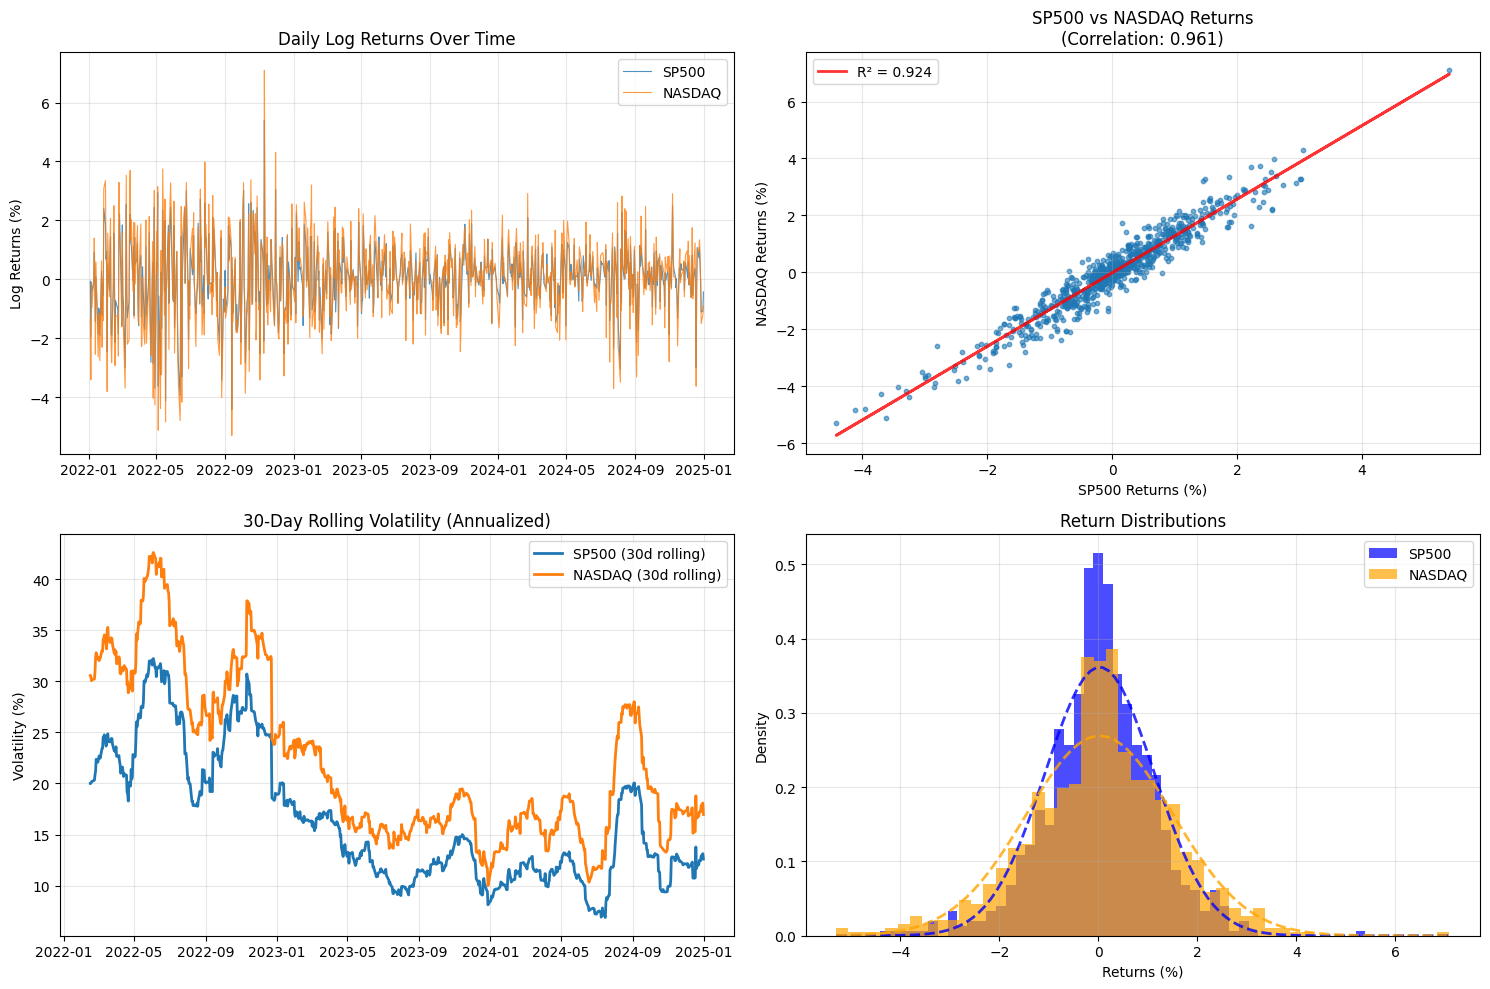


📊 SP500 & NASDAQ DATA OVERVIEW
Data period: 2022-01-04 to 2024-12-31
Total observations: 752

DESCRIPTIVE STATISTICS:
----------------------------------------
  SP500: Mean= 0.027%, Std= 1.10%, Skew=-0.222, Kurt= 1.811
 NASDAQ: Mean= 0.026%, Std= 1.48%, Skew=-0.193, Kurt= 1.211

CORRELATION & VOLATILITY:
----------------------------------------
Correlation coefficient: 0.9614
Annualized volatility - SP500: 17.51%, NASDAQ: 23.53%

EXTREME EVENTS:
----------------------------------------
  SP500: 1% worst days < -3.15% (8 days), 1% best days > 2.57% (8 days)
 NASDAQ: 1% worst days < -4.02% (8 days), 1% best days > 3.32% (8 days)


In [4]:
def plot_sp500_nasdaq_overview(returns_df):
    """
    Create comprehensive plots showing SP500 and NASDAQ data patterns
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Time series of returns (top-left)
    ax1 = axes[0, 0]
    ax1.plot(returns_df.index, returns_df['SP500'], label='SP500', alpha=0.8, linewidth=0.8)
    ax1.plot(returns_df.index, returns_df['NASDAQ'], label='NASDAQ', alpha=0.8, linewidth=0.8)
    ax1.set_title('Daily Log Returns Over Time')
    ax1.set_ylabel('Log Returns (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot of returns (top-right)
    ax2 = axes[0, 1]
    ax2.scatter(returns_df['SP500'], returns_df['NASDAQ'], alpha=0.6, s=10)
    ax2.set_xlabel('SP500 Returns (%)')
    ax2.set_ylabel('NASDAQ Returns (%)')
    ax2.set_title(f'SP500 vs NASDAQ Returns\n(Correlation: {returns_df["SP500"].corr(returns_df["NASDAQ"]):.3f})')
    ax2.grid(True, alpha=0.3)
    
    # Add regression line
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(returns_df['SP500'], returns_df['NASDAQ'])
    line = slope * returns_df['SP500'] + intercept
    ax2.plot(returns_df['SP500'], line, 'r-', alpha=0.8, linewidth=2, label=f'R² = {r_value**2:.3f}')
    ax2.legend()
    
    # 3. Rolling volatility (bottom-left)
    ax3 = axes[1, 0]
    window = 30  # 30-day rolling window
    rolling_vol_sp500 = returns_df['SP500'].rolling(window=window).std() * np.sqrt(252)  # Annualized
    rolling_vol_nasdaq = returns_df['NASDAQ'].rolling(window=window).std() * np.sqrt(252)  # Annualized
    
    ax3.plot(returns_df.index, rolling_vol_sp500, label=f'SP500 ({window}d rolling)', linewidth=2)
    ax3.plot(returns_df.index, rolling_vol_nasdaq, label=f'NASDAQ ({window}d rolling)', linewidth=2)
    ax3.set_title(f'{window}-Day Rolling Volatility (Annualized)')
    ax3.set_ylabel('Volatility (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Distribution comparison (bottom-right)
    ax4 = axes[1, 1]
    ax4.hist(returns_df['SP500'], bins=50, alpha=0.7, label='SP500', density=True, color='blue')
    ax4.hist(returns_df['NASDAQ'], bins=50, alpha=0.7, label='NASDAQ', density=True, color='orange')
    ax4.set_xlabel('Returns (%)')
    ax4.set_ylabel('Density')
    ax4.set_title('Return Distributions')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add normal distribution overlays
    x_range = np.linspace(min(returns_df['SP500'].min(), returns_df['NASDAQ'].min()),
                         max(returns_df['SP500'].max(), returns_df['NASDAQ'].max()), 100)
    
    # SP500 normal overlay
    sp500_normal = stats.norm.pdf(x_range, returns_df['SP500'].mean(), returns_df['SP500'].std())
    ax4.plot(x_range, sp500_normal, 'b--', alpha=0.8, linewidth=2, label='SP500 Normal')
    
    # NASDAQ normal overlay
    nasdaq_normal = stats.norm.pdf(x_range, returns_df['NASDAQ'].mean(), returns_df['NASDAQ'].std())
    ax4.plot(x_range, nasdaq_normal, 'orange', linestyle='--', alpha=0.8, linewidth=2, label='NASDAQ Normal')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print("\n" + "="*60)
    print("📊 SP500 & NASDAQ DATA OVERVIEW")
    print("="*60)
    print(f"Data period: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")
    print(f"Total observations: {len(returns_df)}")
    print()
    
    print("DESCRIPTIVE STATISTICS:")
    print("-" * 40)
    for col in ['SP500', 'NASDAQ']:
        data = returns_df[col]
        print(f"{col:>7}: Mean={data.mean():6.3f}%, Std={data.std():5.2f}%, Skew={data.skew():6.3f}, Kurt={data.kurtosis():6.3f}")
    
    print()
    print("CORRELATION & VOLATILITY:")
    print("-" * 40)
    print(f"Correlation coefficient: {returns_df['SP500'].corr(returns_df['NASDAQ']):.4f}")
    
    # Annualized volatilities
    sp500_ann_vol = returns_df['SP500'].std() * np.sqrt(252)
    nasdaq_ann_vol = returns_df['NASDAQ'].std() * np.sqrt(252)
    print(f"Annualized volatility - SP500: {sp500_ann_vol:.2f}%, NASDAQ: {nasdaq_ann_vol:.2f}%")
    
    # Extreme events
    print()
    print("EXTREME EVENTS:")
    print("-" * 40)
    for col in ['SP500', 'NASDAQ']:
        data = returns_df[col]
        q01 = data.quantile(0.01)
        q99 = data.quantile(0.99)
        extreme_down = (data <= q01).sum()
        extreme_up = (data >= q99).sum()
        print(f"{col:>7}: 1% worst days < {q01:.2f}% ({extreme_down} days), 1% best days > {q99:.2f}% ({extreme_up} days)")

# Create the visualization
plot_sp500_nasdaq_overview(returns_df)

## Split data into train and test

In [7]:
def split_data_2d(returns_df, returns_array, train_ratio=0.8):
    """Split 2D data into training and testing sets"""
    n_total = len(returns_df)
    n_train = int(n_total * train_ratio)
    
    # Split DataFrame
    train_df = returns_df.iloc[:n_train].copy()
    test_df = returns_df.iloc[n_train:].copy()
    
    # Split numpy array
    train_array = returns_array[:n_train]
    test_array = returns_array[n_train:]
    
    print(f"Data split:")
    print(f"  Training: {len(train_df)} days ({train_df.index[0].date()} to {train_df.index[-1].date()})")
    print(f"  Testing:  {len(test_df)} days ({test_df.index[0].date()} to {test_df.index[-1].date()})")
    
    # Print correlation for each split
    print(f"\nTraining set correlation: {train_df['SP500'].corr(train_df['NASDAQ']):.3f}")
    print(f"Testing set correlation:  {test_df['SP500'].corr(test_df['NASDAQ']):.3f}")
    
    return train_df, test_df, train_array, test_array

# Split the data
train_df, test_df, train_array, test_array = split_data_2d(returns_df, returns_array, train_ratio=0.8)

# The arrays are ready for the DC_MSV model
print(f"\nTraining array shape: {train_array.shape}")
print(f"Testing array shape:  {test_array.shape}")

# You can access individual series if needed:
sp500_train = train_df['SP500'].values
nasdaq_train = train_df['NASDAQ'].values
sp500_test = test_df['SP500'].values
nasdaq_test = test_df['NASDAQ'].values

Data split:
  Training: 601 days (2022-01-04 to 2024-05-24)
  Testing:  151 days (2024-05-28 to 2024-12-31)

Training set correlation: 0.962
Testing set correlation:  0.958

Training array shape: (601, 2)
Testing array shape:  (151, 2)


# Defining the model using particles

In [8]:
class DC_MSV(ssm.StateSpaceModel):
    def __init__(self, mu1, mu2, phi11, phi22, sigma_eta1, sigma_eta2, psi0, psi, sigma_rho):
        self.mu1 = mu1
        self.mu2 = mu2
        self.phi11 = phi11
        self.phi22 = phi22
        self.sigma_eta1 = sigma_eta1
        self.sigma_eta2 = sigma_eta2
        self.psi0 = psi0
        self.psi = psi
        self.sigma_rho = sigma_rho
        self.a = np.array([mu1 * (1 - phi11), mu2 * (1 - phi22), psi0 * (1 - psi)])
        self.B = np.diag([phi11, phi22, psi])
        self.Sigma = np.diag([sigma_eta1**2, sigma_eta2**2, sigma_rho**2])

    def PX0(self):
        return distributions.MvNormal(loc=np.array([self.mu1, self.mu2, self.psi0]), cov=np.eye(3))

    def PX(self, t, xp):
        mean = self.a + np.dot(self.B, xp.T).T
        return distributions.MvNormal(loc=mean, cov=self.Sigma)

    def PY(self, t, xp, x):
        h1, h2, q = x[:, 0], x[:, 1], x[:, 2]
        rho = (np.exp(q) - 1) / (np.exp(q) + 1)
        
        # Clip rho to ensure valid correlation
        rho = np.clip(rho, -0.99, 0.99)
        
        N = len(rho)
        means = np.zeros((N, 2))
        
        vol1 = np.exp(h1 / 2)
        vol2 = np.exp(h2 / 2)
        
        # For particles package, we need to return a distribution that can handle vectorized operations
        # We'll use a custom approach where each particle has its own covariance
        class VectorizedMvNormal:
            def __init__(self, means, vol1, vol2, rho):
                self.means = means
                self.vol1 = vol1
                self.vol2 = vol2
                self.rho = rho
                self.N = len(means)
            
            def logpdf(self, y):
                # y should be shape (2,) - the observation
                if len(y.shape) == 1:
                    y = y.reshape(1, -1)  # Make it (1, 2)
                
                logpdfs = np.zeros(self.N)
                for i in range(self.N):
                    # Create covariance matrix for particle i
                    cov_i = np.array([[self.vol1[i]**2 + 1e-6, self.rho[i] * self.vol1[i] * self.vol2[i]],
                                     [self.rho[i] * self.vol1[i] * self.vol2[i], self.vol2[i]**2 + 1e-6]])
                    
                    # Calculate log pdf for this particle
                    diff = y[0] - self.means[i]  # y[0] because y is (1, 2)
                    
                    # Manual calculation of multivariate normal log pdf
                    det_cov = np.linalg.det(cov_i)
                    if det_cov <= 0:
                        logpdfs[i] = -np.inf
                    else:
                        inv_cov = np.linalg.inv(cov_i)
                        exponent = -0.5 * diff @ inv_cov @ diff.T
                        normalization = -0.5 * (2 * np.log(2 * np.pi) + np.log(det_cov))
                        logpdfs[i] = exponent + normalization
                
                return logpdfs
            
            def rvs(self, size=None):
                if size is None:
                    size = self.N
                samples = np.zeros((size, 2))
                for i in range(size):
                    # Use modulo to cycle through particles if size > N
                    particle_idx = i % self.N
                    cov_i = np.array([[self.vol1[particle_idx]**2 + 1e-6, self.rho[particle_idx] * self.vol1[particle_idx] * self.vol2[particle_idx]],
                                     [self.rho[particle_idx] * self.vol1[particle_idx] * self.vol2[particle_idx], self.vol2[particle_idx]**2 + 1e-6]])
                    samples[i] = np.random.multivariate_normal(self.means[particle_idx], cov_i)
                return samples
        
        return VectorizedMvNormal(means, vol1, vol2, rho)

## B-Scholes alternative (bivariate normal)

In [9]:
class BivariateNormal(ssm.StateSpaceModel):
    """
    Simple constant bivariate normal model (2D Black-Scholes equivalent)
    """
    def __init__(self, data):
        # Calculate mean and covariance from data
        self.data = np.array(data)
        self.mean = np.mean(self.data, axis=0)  # Should be close to [0, 0]
        self.cov = np.cov(self.data.T)  # 2x2 constant covariance matrix
    
    def PX0(self):
        """Dummy initial state - not really used"""
        return distributions.MvNormal(loc=np.zeros(2), cov=0.001 * np.eye(2))
    
    def PX(self, t, xp):
        """Dummy state transition - essentially no change"""
        return distributions.MvNormal(loc=xp, cov=0.0001 * np.eye(2))
    
    def PY(self, t, xp, x):
        """Observation model: Y_t ~ N(μ, Σ) with constant μ, Σ"""
        N = len(x)
        
        # Custom distribution for constant bivariate normal
        class ConstantBivariateNormal:
            def __init__(self, mean, cov, N):
                self.mean = mean
                self.cov = cov + 1e-6 * np.eye(2)  # Add regularization
                self.N = N
            
            def logpdf(self, y):
                # y should be shape (2,) - the observation
                if len(y.shape) == 1:
                    y = y.reshape(1, -1)  # Make it (1, 2)
                
                # All particles have the same likelihood under constant model
                diff = y[0] - self.mean  # y[0] because y is (1, 2)
                
                # Manual calculation of multivariate normal log pdf
                det_cov = np.linalg.det(self.cov)
                if det_cov <= 0:
                    return np.full(self.N, -np.inf)
                
                inv_cov = np.linalg.inv(self.cov)
                exponent = -0.5 * diff @ inv_cov @ diff.T
                normalization = -0.5 * (2 * np.log(2 * np.pi) + np.log(det_cov))
                logpdf_val = exponent + normalization
                
                return np.full(self.N, logpdf_val)
            
            def rvs(self, size=None):
                if size is None:
                    size = self.N
                return np.random.multivariate_normal(self.mean, self.cov, size)
        
        return ConstantBivariateNormal(self.mean, self.cov, N)

# Bayesian Estimation

In [10]:
import numpy as np
import jax.numpy as jnp
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def numpyro_estimation_dc_msv(returns_array, n_iter=10000, n_warmup=2000, n_chains=2):
    """
    Optimized HMC estimation for DC-MSV model using non-centered parameterization.
    """
    jax.config.update("jax_platform_name", "cpu")
    
    T, _ = returns_array.shape
    y_data = jnp.array(returns_array)
    
    def dc_msv_model(y=None):
        # Priors
        mu1 = numpyro.sample('mu1', dist.Normal(0., 5.))
        mu2 = numpyro.sample('mu2', dist.Normal(0., 5.))
        phi11 = numpyro.sample('phi11', dist.Beta(20., 1.5))
        phi22 = numpyro.sample('phi22', dist.Beta(20., 1.5))
        sigma1 = numpyro.sample('sigma1', dist.InverseGamma(2.5, 0.025))
        sigma2 = numpyro.sample('sigma2', dist.InverseGamma(2.5, 0.025))
        mu0 = numpyro.sample('mu0', dist.Normal(0.7, 3.))
        phi = numpyro.sample('phi', dist.Beta(20., 1.5))
        sigma_rho = numpyro.sample('sigma_rho', dist.InverseGamma(2.5, 0.025))

        # Stationary variances for initial states
        var_h1 = sigma1**2 / (1 - phi11**2 + 1e-6)  # Add epsilon to avoid div by zero if phi~1
        var_h2 = sigma2**2 / (1 - phi22**2 + 1e-6)
        var_q = sigma_rho**2 / (1 - phi**2 + 1e-6)

        # Initial tildes
        h1_0_tilde = numpyro.sample('h1_0_tilde', dist.Normal(0., 1.))
        h2_0_tilde = numpyro.sample('h2_0_tilde', dist.Normal(0., 1.))
        q_0_tilde = numpyro.sample('q_0_tilde', dist.Normal(0., 1.))

        # Initial states
        h1_init = mu1 + jnp.sqrt(var_h1) * h1_0_tilde
        h2_init = mu2 + jnp.sqrt(var_h2) * h2_0_tilde
        q_init = mu0 + jnp.sqrt(var_q) * q_0_tilde
        init_state = jnp.array([h1_init, h2_init, q_init])

        # Non-centered innovations for transitions (t=1 to T)
        with numpyro.plate('time', T-1):
            h1_tilde = numpyro.sample('h1_tilde', dist.Normal(0., 1.))
            h2_tilde = numpyro.sample('h2_tilde', dist.Normal(0., 1.))
            q_tilde = numpyro.sample('q_tilde', dist.Normal(0., 1.))

        # Stack tildes: shape (T-1, 3)
        tildes = jnp.stack([h1_tilde, h2_tilde, q_tilde], axis=1)

        # Scan function for state transitions
        def state_step(state_prev, tilde):
            h1_prev, h2_prev, q_prev = state_prev
            h1 = mu1 + phi11 * (h1_prev - mu1) + sigma1 * tilde[0]
            h2 = mu2 + phi22 * (h2_prev - mu2) + sigma2 * tilde[1]
            q = mu0 + phi * (q_prev - mu0) + sigma_rho * tilde[2]
            new_state = jnp.array([h1, h2, q])
            return new_state, new_state

        # Run scan to get states[1:] 
        _, states_rest = lax.scan(state_step, init_state, tildes)

        # Full states: init + rest, shape (T, 3)
        states = jnp.concatenate([init_state[None, :], states_rest], axis=0)

        # Store states explicitly
        numpyro.deterministic('states', states)

        # Observation model
        with numpyro.plate('obs', T):
            h1, h2, q = states[:, 0], states[:, 1], states[:, 2]
            rho_t = (jnp.exp(q) - 1) / (jnp.exp(q) + 1)
            Omega_t = jnp.stack([jnp.exp(h1 / 2), jnp.exp(h2 / 2)], axis=1)
            covs = jnp.zeros((T, 2, 2))
            covs = covs.at[:, 0, 0].set(Omega_t[:, 0]**2)
            covs = covs.at[:, 1, 1].set(Omega_t[:, 1]**2)
            covs = covs.at[:, 0, 1].set(rho_t * Omega_t[:, 0] * Omega_t[:, 1])
            covs = covs.at[:, 1, 0].set(rho_t * Omega_t[:, 0] * Omega_t[:, 1])
            covs = covs + 1e-5 * jnp.eye(2)
            numpyro.sample('y', dist.MultivariateNormal(loc=jnp.zeros(2), covariance_matrix=covs), obs=y)

    print(f"Running optimized DC-MSV estimation with NumPyro...")
    
    # Run NUTS
    nuts_kernel = NUTS(dc_msv_model)
    mcmc = MCMC(
        nuts_kernel,
        num_warmup=n_warmup,
        num_samples=n_iter - n_warmup,
        num_chains=n_chains,
        progress_bar=True
    )
    
    mcmc.run(jax.random.PRNGKey(0), y=y_data)
    
    # Extract samples
    samples = mcmc.get_samples()
    
    # Parameter estimates
    params = ['mu1', 'mu2', 'phi11', 'phi22', 'sigma1', 'sigma2', 'mu0', 'phi', 'sigma_rho']
    param_estimates = {}
    
    for param in params:
        param_samples = samples[param]
        param_estimates[param] = {
            'mean': float(jnp.mean(param_samples)),
            'std': float(jnp.std(param_samples)),
            'quantiles': [float(q) for q in jnp.quantile(param_samples, jnp.array([0.025, 0.5, 0.975]))]
        }
    
    print("\n✓ NumPyro estimation completed")
    print("\nParameter estimates:")
    for param, est in param_estimates.items():
        print(f"  {param}: {est['mean']:.4f} ± {est['std']:.4f}")
    
    return {
        'mcmc': mcmc,
        'samples': samples,
        'estimates': param_estimates,
        'param_names': params
    }

In [11]:
# 1. Fetch 2D data
returns_df, returns_array = fetch_sp500_nasdaq_data()

# 2. Split the data
train_df, test_df, train_array, test_array = split_data_2d(returns_df, returns_array, train_ratio=0.8)

# 3. Convert percentage returns to decimal returns
train_array_decimal = train_array / 100
test_array_decimal = test_array / 100

# 4. Create baseline model (FIX HERE)
baseline_model = BivariateNormal(train_array_decimal)

# Run parameter estimation
print("Running efficient estimation...")
results = numpyro_estimation_dc_msv(train_array_decimal, n_iter=10000, n_warmup=2000)

Downloaded 752 trading days

Summary Statistics:
S&P 500  - Mean: 0.027%, Std: 1.10%
NASDAQ   - Mean: 0.026%, Std: 1.48%
Correlation: 0.961
Data split:
  Training: 601 days (2022-01-04 to 2024-05-24)
  Testing:  151 days (2024-05-28 to 2024-12-31)

Training set correlation: 0.962
Testing set correlation:  0.958
Running efficient estimation...
Running optimized DC-MSV estimation with NumPyro...
Running optimized DC-MSV estimation with NumPyro...


sample: 100%|██████████| 10000/10000 [07:29<00:00, 22.24it/s, 255 steps of size 1.89e-02. acc. prob=0.94]

sample: 100%|██████████| 10000/10000 [04:11<00:00, 39.71it/s, 127 steps of size 2.60e-02. acc. prob=0.87]




✓ NumPyro estimation completed

Parameter estimates:
  mu1: -9.1494 ± 0.6418
  mu2: -8.3785 ± 0.6829
  phi11: 0.9970 ± 0.0022
  phi22: 0.9979 ± 0.0017
  sigma1: 0.0417 ± 0.0098
  sigma2: 0.0349 ± 0.0083
  mu0: 8.4709 ± 1.1821
  phi: 0.9300 ± 0.0543
  sigma_rho: 0.0164 ± 0.0184



📊 DC_MSV MCMC Convergence Diagnostics:
Total iterations: 16000
Burn-in samples: 0
Post-burn samples: 16000

Effective Sample Sizes:

Volatility parameters:
  mu1: 1769.9 (11.1% of total)
  mu2: 1242.2 (7.8% of total)
  phi11: 4010.7 (25.1% of total)
  phi22: 4216.6 (26.4% of total)
  sigma1: 3482.5 (21.8% of total)
  sigma2: 4216.8 (26.4% of total)

Correlation parameters:
  mu0: 9137.7 (57.1% of total)
  phi: 15167.1 (94.8% of total)
  sigma_rho: 4596.5 (28.7% of total)


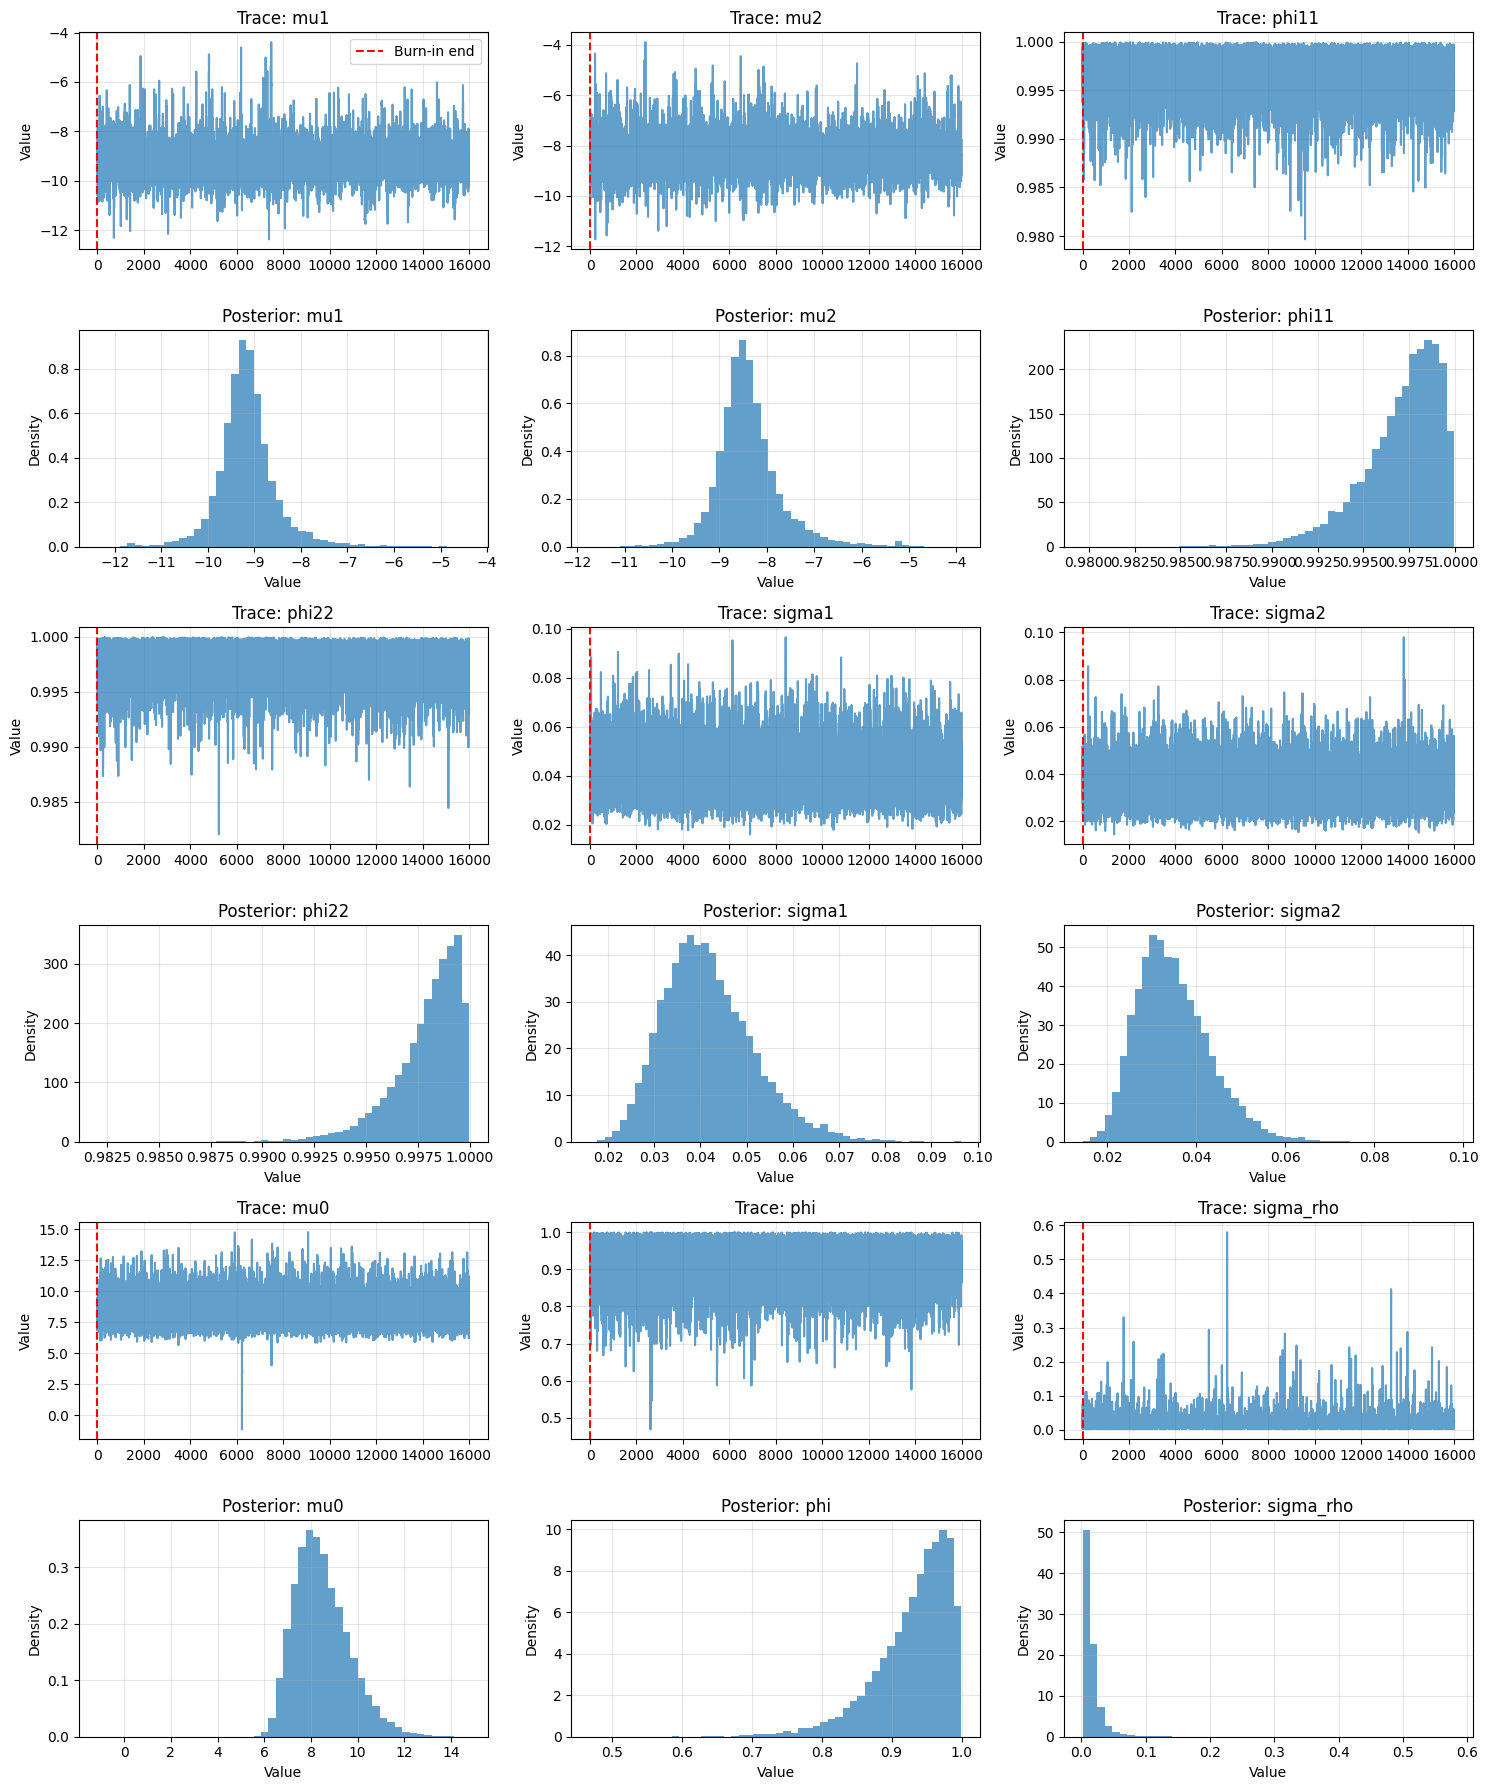

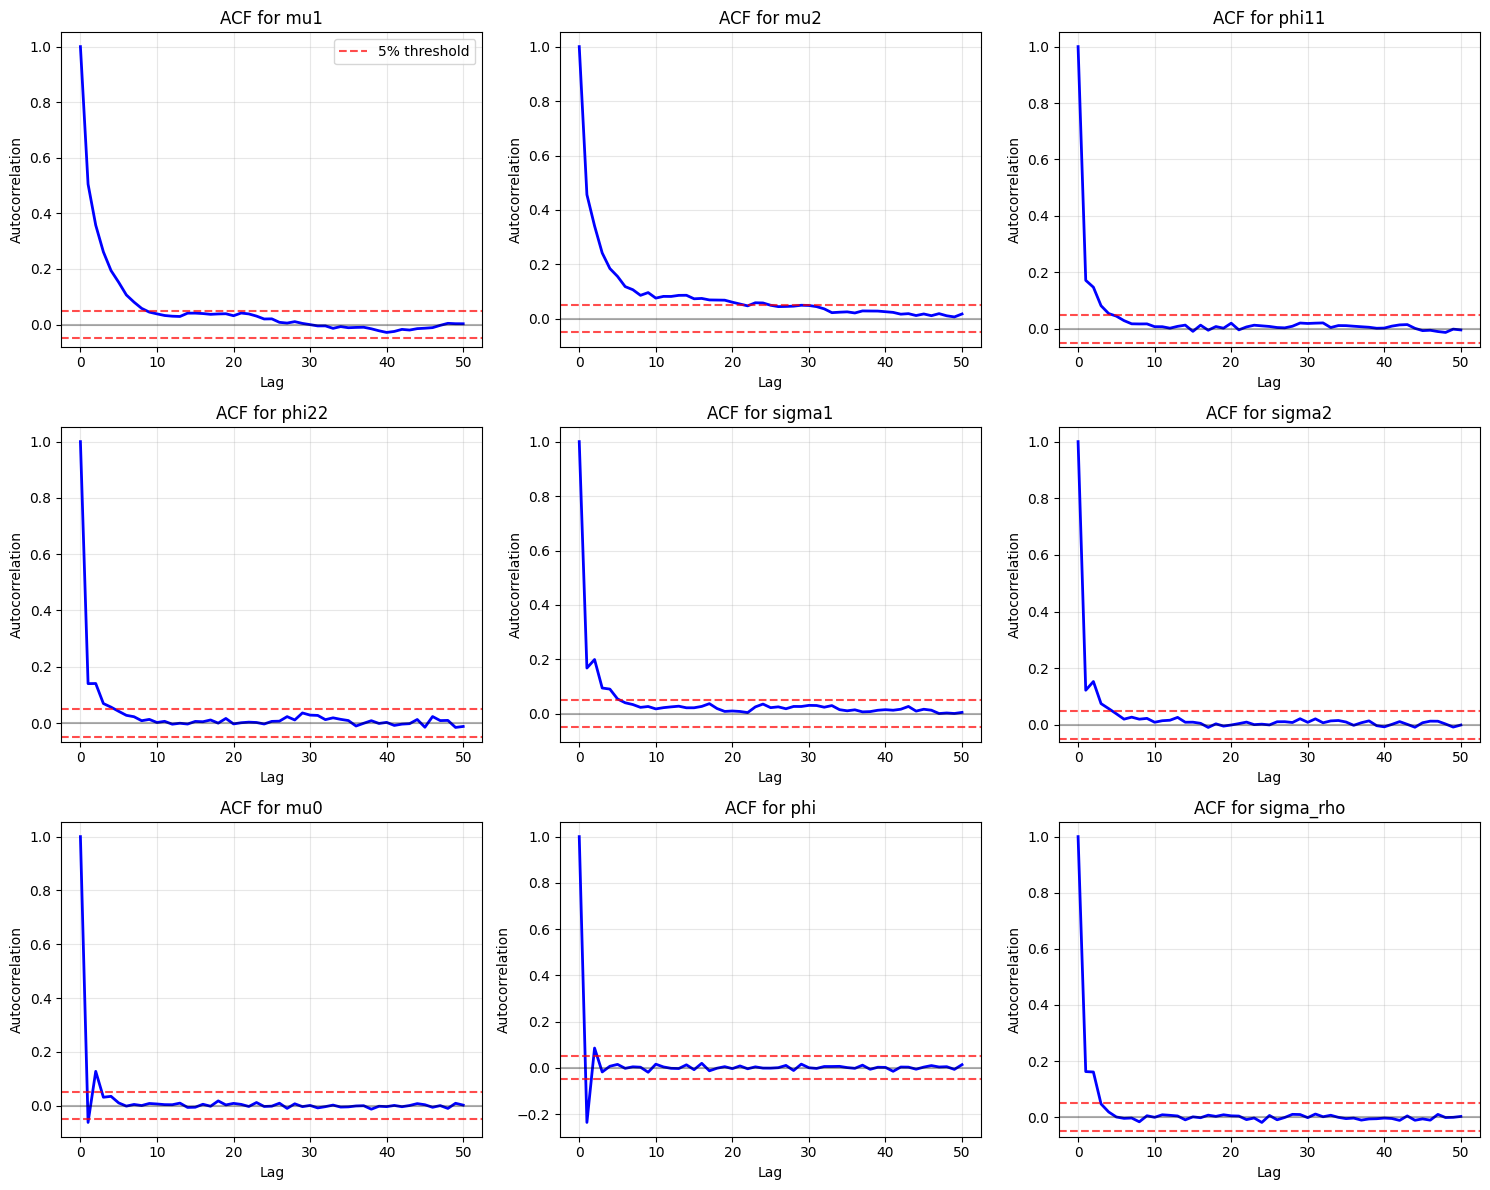


📈 Parameter Summary Statistics:
--------------------------------------------------
Parameter    Mean       Std        95% CI              
--------------------------------------------------
mu1          -9.1494    0.6418     [-10.3402, -7.6974]
mu2          -8.3785    0.6829     [-9.5271, -6.7154]
phi11        0.9970     0.0022     [0.9916, 0.9997]
phi22        0.9979     0.0017     [0.9935, 0.9998]
sigma1       0.0417     0.0098     [0.0256, 0.0643]
sigma2       0.0349     0.0083     [0.0217, 0.0536]
mu0          8.4709     1.1821     [6.6261, 11.1531]
phi          0.9300     0.0543     [0.7926, 0.9948]
sigma_rho    0.0164     0.0184     [0.0039, 0.0593]

📊 NumPyro-Specific Diagnostics:
R-hat values not available

Posterior Summary:
------------------------------------------------------------
Parameter    Mean       Std        2.5%       97.5%     
------------------------------------------------------------
mu1          -9.1494    0.6418     -10.3402   -7.6974   
mu2          -8.378

In [10]:
def plot_acf(chain, param_names, max_lags=50):
    """Plot autocorrelation function for MCMC chains"""
    from statsmodels.tsa.stattools import acf
    
    n_params = len(param_names)
    n_cols = 3  # Display 3 columns for better layout with 9 parameters
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_params > 1 else [axes]
    
    for i, param in enumerate(param_names):
        # Calculate ACF
        autocorr = acf(chain[:, i], nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))
        
        axes[i].plot(lags, autocorr, 'b-', linewidth=2)
        axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% threshold')
        axes[i].axhline(y=-0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Autocorrelation')
        axes[i].set_title(f'ACF for {param}')
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend()
    
    # Hide empty subplots
    for i in range(n_params, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def effective_sample_size(chain):
    """Calculate effective sample size for MCMC chains"""
    from statsmodels.tsa.stattools import acf
    
    n_samples, n_params = chain.shape
    ess_values = []
    
    for i in range(n_params):
        # Calculate autocorrelation
        max_lags = min(n_samples // 4, 200)
        try:
            autocorrs = acf(chain[:, i], nlags=max_lags, fft=True)
            
            # Find first negative autocorrelation or where it drops below 0.05
            cutoff = 1
            for lag in range(1, len(autocorrs)):
                if autocorrs[lag] <= 0.05:
                    cutoff = lag
                    break
            
            # Calculate integrated autocorrelation time
            tau_int = 1 + 2 * np.sum(autocorrs[1:cutoff+1])
            
            # Effective sample size
            ess = n_samples / (2 * tau_int)
            ess_values.append(max(ess, 1))
            
        except:
            # Fallback calculation
            ess_values.append(n_samples / 10)
    
    return np.array(ess_values)

def mcmc_diagnostics_2d(chain, param_names, burned_chain):
    """Comprehensive MCMC diagnostics for DC_MSV model"""
    print("\n📊 DC_MSV MCMC Convergence Diagnostics:")
    print("=" * 50)
    
    # Basic chain statistics
    n_total, n_params = chain.shape
    n_burned = len(burned_chain)
    
    print(f"Total iterations: {n_total}")
    print(f"Burn-in samples: {n_total - n_burned}")
    print(f"Post-burn samples: {n_burned}")
    
    # Effective sample size
    ess = effective_sample_size(burned_chain)
    print(f"\nEffective Sample Sizes:")
    
    # Group parameters by type for better display
    vol_params = ['mu1', 'mu2', 'phi11', 'phi22', 'sigma1', 'sigma2']
    corr_params = ['mu0', 'phi', 'sigma_rho']
    
    print("\nVolatility parameters:")
    for param in vol_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"  {param}: {ess[i]:.1f} ({ess[i]/n_burned:.1%} of total)")
    
    print("\nCorrelation parameters:")
    for param in corr_params:
        if param in param_names:
            i = param_names.index(param)
            print(f"  {param}: {ess[i]:.1f} ({ess[i]/n_burned:.1%} of total)")
    
    # Plot traces and densities in a grid layout
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(15, n_rows * 6))
    
    for i, param in enumerate(param_names):
        row_trace = 2 * (i // n_cols)
        row_dens = row_trace + 1
        col = i % n_cols
        
        # Trace plot
        axes[row_trace, col].plot(chain[:, i], alpha=0.7)
        axes[row_trace, col].axvline(x=n_total-n_burned, color='r', linestyle='--', 
                                     label='Burn-in end')
        axes[row_trace, col].set_title(f'Trace: {param}')
        axes[row_trace, col].set_ylabel('Value')
        axes[row_trace, col].grid(True, alpha=0.3)
        if i == 0:
            axes[row_trace, col].legend()
        
        # Density plot
        axes[row_dens, col].hist(burned_chain[:, i], bins=50, density=True, alpha=0.7)
        axes[row_dens, col].set_title(f'Posterior: {param}')
        axes[row_dens, col].set_xlabel('Value')
        axes[row_dens, col].set_ylabel('Density')
        axes[row_dens, col].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_params, n_rows * n_cols):
        row_trace = 2 * (i // n_cols)
        row_dens = row_trace + 1
        col = i % n_cols
        axes[row_trace, col].set_visible(False)
        axes[row_dens, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # ACF plots
    plot_acf(burned_chain, param_names)
    
    # Summary statistics
    print("\n📈 Parameter Summary Statistics:")
    print("-" * 50)
    print(f"{'Parameter':<12} {'Mean':<10} {'Std':<10} {'95% CI':<20}")
    print("-" * 50)
    
    for i, param in enumerate(param_names):
        mean = np.mean(burned_chain[:, i])
        std = np.std(burned_chain[:, i])
        ci_low, ci_high = np.percentile(burned_chain[:, i], [2.5, 97.5])
        print(f"{param:<12} {mean:<10.4f} {std:<10.4f} [{ci_low:.4f}, {ci_high:.4f}]")
    
    return ess

def convert_numpyro_to_chain(numpyro_results):
    """Convert NumPyro results to chain format for diagnostics"""
    samples = numpyro_results['samples']
    param_names = numpyro_results['param_names']
    
    # Get number of samples
    n_samples = len(samples[param_names[0]])
    n_params = len(param_names)
    
    # Create chain array
    chain = np.zeros((n_samples, n_params))
    for i, param in enumerate(param_names):
        chain[:, i] = np.array(samples[param])
    
    # NumPyro already excludes warmup, so burned_chain = chain
    burned_chain = chain
    
    return chain, burned_chain

# Convert NumPyro results to chain format
chain, burned_chain = convert_numpyro_to_chain(results)

# Run diagnostics
ess = mcmc_diagnostics_2d(chain, 
                         results['param_names'], 
                         burned_chain)

# Additional NumPyro-specific diagnostics
print("\n📊 NumPyro-Specific Diagnostics:")
print("=" * 50)

# Get r_hat values if available
if hasattr(results['mcmc'], 'get_extra_fields'):
    try:
        r_hat = results['mcmc'].get_extra_fields()['r_hat']
        print("\nGelman-Rubin R-hat values:")
        for i, param in enumerate(results['param_names']):
            if param in r_hat:
                print(f"  {param}: {r_hat[param]:.3f}")
    except:
        print("R-hat values not available")

# Print summary statistics
print("\nPosterior Summary:")
print("-" * 60)
print(f"{'Parameter':<12} {'Mean':<10} {'Std':<10} {'2.5%':<10} {'97.5%':<10}")
print("-" * 60)
for param in results['param_names']:
    est = results['estimates'][param]
    print(f"{param:<12} {est['mean']:<10.4f} {est['std']:<10.4f} "
          f"{est['quantiles'][0]:<10.4f} {est['quantiles'][2]:<10.4f}")

# NLPD Case

## Online Case

Running DC-MSV particle filter...
Running Bivariate Normal particle filter...
Running Bivariate Normal particle filter...

🔍 DC-MSV Focused Spike Detection:
DC-MSV outliers detected: 4 out of 150 (2.7%)
Bivariate: NO spike removal (kept original)
DC-MSV spike values: [-3.56956255 -4.37385337  3.50174577 18.25029319]

🔍 DC-MSV Focused Spike Detection:
DC-MSV outliers detected: 4 out of 150 (2.7%)
Bivariate: NO spike removal (kept original)
DC-MSV spike values: [-3.56956255 -4.37385337  3.50174577 18.25029319]


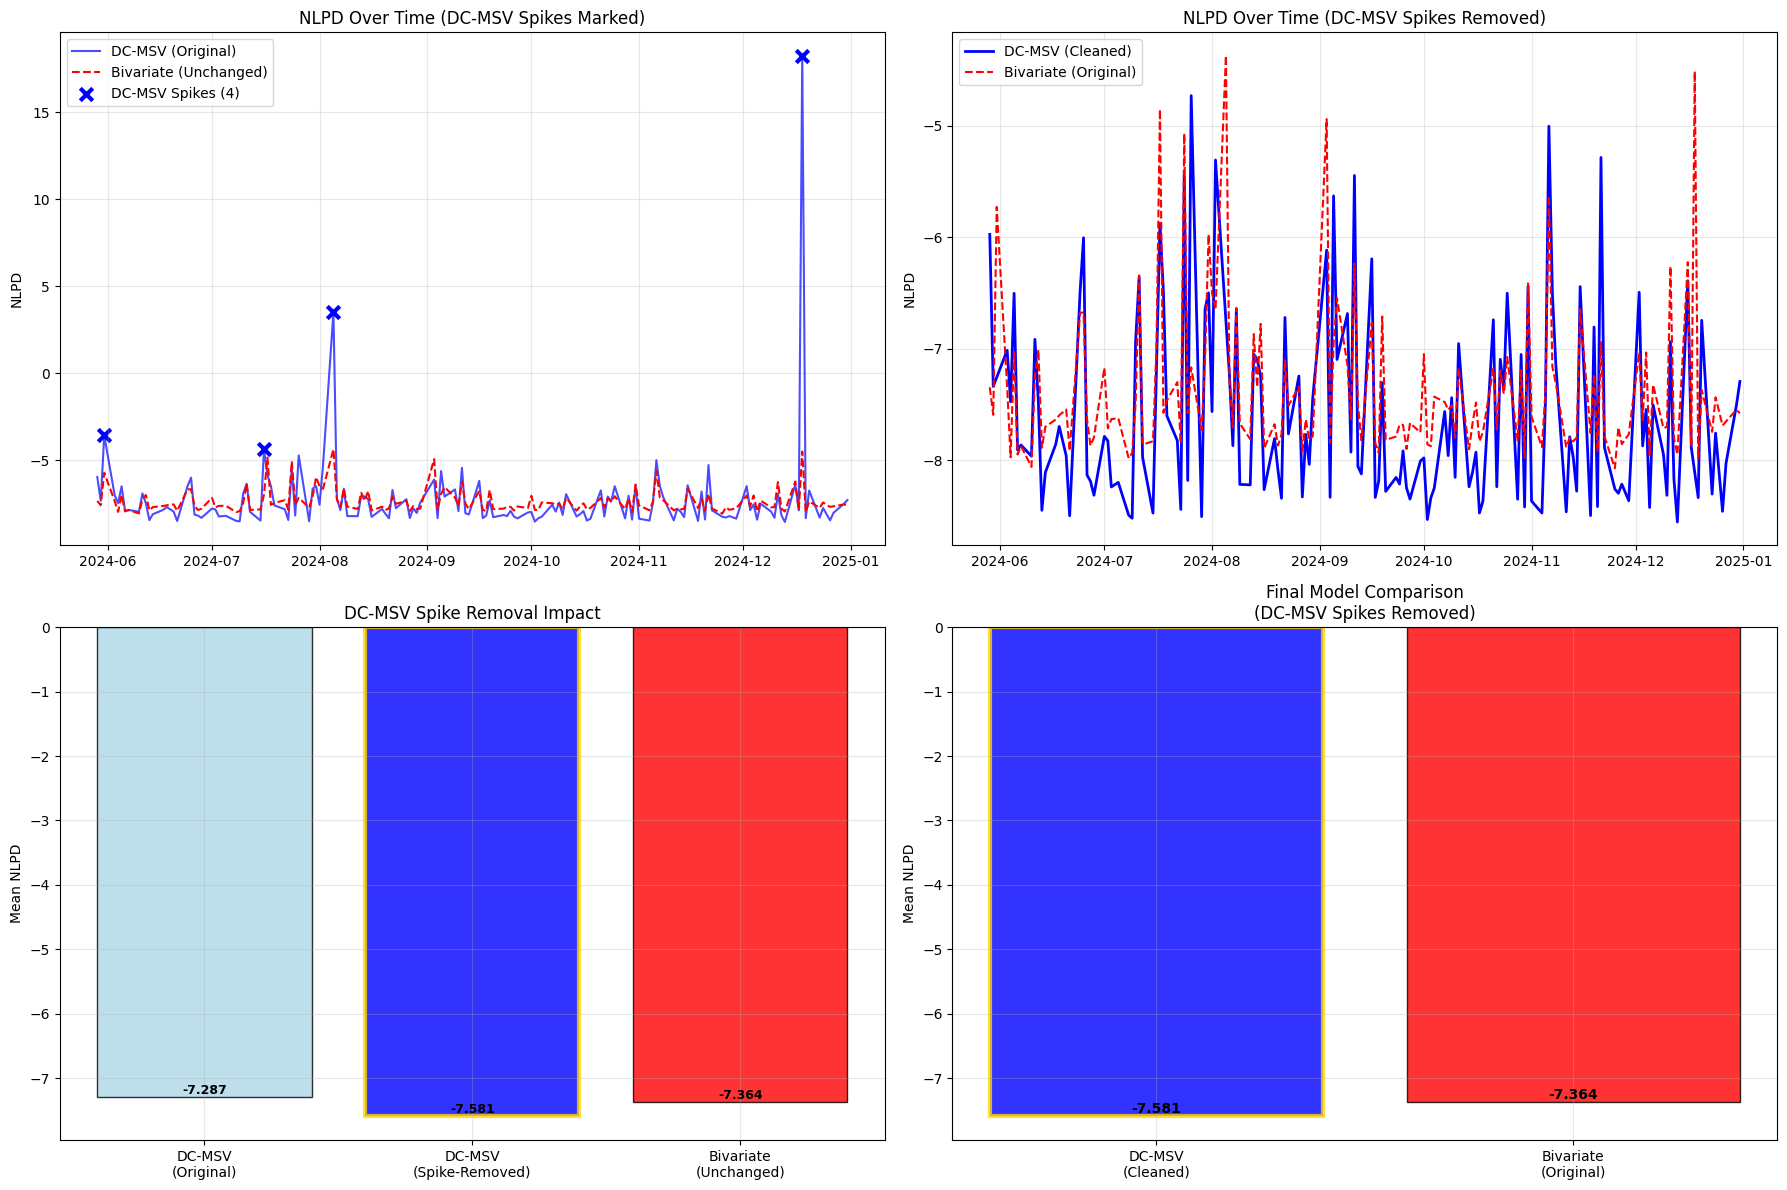


📊 DC-MSV Focused NLPD Comparison:
Model                     Mean NLPD    Total NLPD  
------------------------------------------------------------
DC-MSV (Original)         -7.287       -1093.1     
DC-MSV (Spike-Removed)    -7.581       -1106.9     
Bivariate (Unchanged)     -7.364       -1104.6     

🎯 DC-MSV SPIKE IMPACT:
Spike removal improved DC-MSV by: 0.2942 NLPD points
Improvement percentage: -4.04%

🏆 FINAL RESULT: DC-MSV (cleaned) WINS by 0.2174 NLPD points!

Median comparison (naturally robust):
DC-MSV median: -7.870
Bivariate median: -7.627
Median winner: DC-MSV


<Figure size 640x480 with 0 Axes>


📊 Robust NLPD Model Comparison:
Metric               DC-MSV       Bivariate    Winner         
------------------------------------------------------------
ORIGINAL DATA (with spikes):
Mean NLPD            -7.287       -7.364       Bivariate      
Median NLPD          -7.870       -7.627       DC-MSV         
Total NLPD           -1093.1      -1104.6      Bivariate      

ROBUST DATA (spikes removed):
Mean NLPD            -7.581       -7.494       DC-MSV         
Total NLPD           -1106.9      -1071.6      DC-MSV         

🎯 SPIKE IMPACT ANALYSIS:
DC-MSV: Mean difference = 0.294 (spikes vs clean)
Bivariate: Mean difference = 0.130 (spikes vs clean)
Median is robust - no change needed!

🏆 ROBUST WINNER: DC-MSV (based on spike-removed mean NLPD)


In [16]:
# DC-MSV Focused Spike Removal: Only remove spikes from DC-MSV, keep Bivariate as-is
# Using imported NLPD from particles_cdssm.collectors

def detect_outliers_dc_only(data, method='iqr', factor=2.0):
    """Detect outliers using IQR method - focused on DC-MSV only"""
    data = np.array(data)
    
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    
    return outliers, data[~outliers]

def compare_models_nlpd_dc_focused():
    # Setup models
    params = results['estimates']
    dc_msv = DC_MSV(params['mu1']['mean'], params['mu2']['mean'], 
                    params['phi11']['mean'], params['phi22']['mean'],
                    params['sigma1']['mean'], params['sigma2']['mean'], 
                    params['mu0']['mean'], params['phi']['mean'], 
                    params['sigma_rho']['mean'])
    
    bivariate = BivariateNormal(train_array_decimal)
    
    # Run filters
    print("Running DC-MSV particle filter...")
    fk_dc = ssm.Bootstrap(ssm=dc_msv, data=test_array_decimal)
    smc_dc = particles.SMC(fk=fk_dc, N=500, collect=[NLPD])
    smc_dc.run()
    
    print("Running Bivariate Normal particle filter...")
    fk_biv = ssm.Bootstrap(ssm=bivariate, data=test_array_decimal)
    smc_biv = particles.SMC(fk=fk_biv, N=500, collect=[NLPD])
    smc_biv.run()
    
    # Clean results
    nlpd_dc_raw = [x for x in smc_dc.summaries.nlpd if x is not None]
    nlpd_biv_raw = [x for x in smc_biv.summaries.nlpd if x is not None]
    
    return nlpd_dc_raw, nlpd_biv_raw

# Compare models
nlpd_dc_msv, nlpd_bivariate = compare_models_nlpd_dc_focused()

# Convert to numpy arrays
nlpd_dc_array = np.array(nlpd_dc_msv)
nlpd_biv_array = np.array(nlpd_bivariate)  # Keep bivariate unchanged

# ONLY detect outliers for DC-MSV
outliers_dc, nlpd_dc_clean = detect_outliers_dc_only(nlpd_dc_array, method='iqr', factor=2.0)

print(f"\n🔍 DC-MSV Focused Spike Detection:")
print(f"DC-MSV outliers detected: {np.sum(outliers_dc)} out of {len(nlpd_dc_array)} ({np.sum(outliers_dc)/len(nlpd_dc_array)*100:.1f}%)")
print(f"Bivariate: NO spike removal (kept original)")

if np.sum(outliers_dc) > 0:
    spike_values_dc = nlpd_dc_array[outliers_dc]
    print(f"DC-MSV spike values: {spike_values_dc}")

# Create 4 plots: original with DC spikes marked, cleaned time series, DC-focused comparison, robust final comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Time series with ONLY DC-MSV spikes highlighted
dates = test_df.index[-len(nlpd_dc_array):]
axes[0,0].plot(dates, nlpd_dc_array, 'b-', label='DC-MSV (Original)', linewidth=1.5, alpha=0.7)
axes[0,0].plot(dates, nlpd_biv_array, 'r--', label='Bivariate (Unchanged)', linewidth=1.5)

# Highlight ONLY DC-MSV spikes
if np.sum(outliers_dc) > 0:
    spike_indices_dc = np.where(outliers_dc)[0]
    spike_dates_dc = dates[spike_indices_dc]
    spike_values_dc = nlpd_dc_array[outliers_dc]
    axes[0,0].scatter(spike_dates_dc, spike_values_dc, color='blue', s=80, marker='x', 
                     linewidth=3, label=f'DC-MSV Spikes ({np.sum(outliers_dc)})')

axes[0,0].set_title('NLPD Over Time (DC-MSV Spikes Marked)')
axes[0,0].set_ylabel('NLPD')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Cleaned time series (DC-MSV spikes removed)
clean_indices_dc = np.where(~outliers_dc)[0]
clean_dates_dc = dates[clean_indices_dc]

axes[0,1].plot(clean_dates_dc, nlpd_dc_clean, 'b-', label='DC-MSV (Cleaned)', linewidth=2)
axes[0,1].plot(dates, nlpd_biv_array, 'r--', label='Bivariate (Original)', linewidth=1.5)
axes[0,1].set_title('NLPD Over Time (DC-MSV Spikes Removed)')
axes[0,1].set_ylabel('NLPD')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. DC-MSV: Original vs Spike-Removed comparison
dc_mean_orig = np.mean(nlpd_dc_array)
dc_mean_clean = np.mean(nlpd_dc_clean)
biv_mean = np.mean(nlpd_biv_array)  # Unchanged

models_dc = ['DC-MSV\n(Original)', 'DC-MSV\n(Spike-Removed)', 'Bivariate\n(Unchanged)']
means_dc = [dc_mean_orig, dc_mean_clean, biv_mean]
colors_dc = ['lightblue', 'blue', 'red']

bars1 = axes[1,0].bar(models_dc, means_dc, color=colors_dc, alpha=0.8, edgecolor='black')
axes[1,0].set_title('DC-MSV Spike Removal Impact')
axes[1,0].set_ylabel('Mean NLPD')
axes[1,0].grid(True, alpha=0.3)

# Add value labels and highlight best
for i, (bar, value) in enumerate(zip(bars1, means_dc)):
    axes[1,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.002,
                  f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Highlight the winner
winner_idx = np.argmin(means_dc)
bars1[winner_idx].set_edgecolor('gold')
bars1[winner_idx].set_linewidth(3)

# 4. Final robust comparison (DC-MSV cleaned vs Bivariate original)
final_models = ['DC-MSV\n(Cleaned)', 'Bivariate\n(Original)']
final_means = [dc_mean_clean, biv_mean]
final_colors = ['blue', 'red']

bars2 = axes[1,1].bar(final_models, final_means, color=final_colors, alpha=0.8, edgecolor='black')
axes[1,1].set_title('Final Model Comparison\n(DC-MSV Spikes Removed)')
axes[1,1].set_ylabel('Mean NLPD')
axes[1,1].grid(True, alpha=0.3)

# Add value labels and highlight winner
for bar, value in zip(bars2, final_means):
    axes[1,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.002,
                  f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

final_winner_idx = 0 if dc_mean_clean < biv_mean else 1
bars2[final_winner_idx].set_edgecolor('gold')
bars2[final_winner_idx].set_linewidth(3)

plt.tight_layout()
plt.show()

# DC-MSV focused statistics
print(f"\n📊 DC-MSV Focused NLPD Comparison:")
print("=" * 60)
print(f"{'Model':<25} {'Mean NLPD':<12} {'Total NLPD':<12}")
print("-" * 60)
print(f"{'DC-MSV (Original)':<25} {dc_mean_orig:<12.3f} {np.sum(nlpd_dc_array):<12.1f}")
print(f"{'DC-MSV (Spike-Removed)':<25} {dc_mean_clean:<12.3f} {np.sum(nlpd_dc_clean):<12.1f}")
print(f"{'Bivariate (Unchanged)':<25} {biv_mean:<12.3f} {np.sum(nlpd_biv_array):<12.1f}")

print(f"\n🎯 DC-MSV SPIKE IMPACT:")
spike_impact = dc_mean_orig - dc_mean_clean
print(f"Spike removal improved DC-MSV by: {spike_impact:.4f} NLPD points")
print(f"Improvement percentage: {(spike_impact/dc_mean_orig)*100:.2f}%")

# Final verdict
if dc_mean_clean < biv_mean:
    improvement = biv_mean - dc_mean_clean
    print(f"\n🏆 FINAL RESULT: DC-MSV (cleaned) WINS by {improvement:.4f} NLPD points!")
else:
    deficit = dc_mean_clean - biv_mean
    print(f"\n📊 FINAL RESULT: Bivariate still wins by {deficit:.4f} NLPD points")

print(f"\nMedian comparison (naturally robust):")
dc_median = np.median(nlpd_dc_array)
biv_median = np.median(nlpd_biv_array)
print(f"DC-MSV median: {dc_median:.3f}")
print(f"Bivariate median: {biv_median:.3f}")
median_winner = "DC-MSV" if dc_median < biv_median else "Bivariate"
print(f"Median winner: {median_winner}")

# 1. Original time series with spikes highlighted
dates = test_df.index[-len(nlpd_dc_array):]
axes[0,0].plot(dates, nlpd_dc_array, 'b-', label='DC-MSV (Original)', linewidth=1.5, alpha=0.7)
axes[0,0].plot(dates, nlpd_biv_array, 'r--', label='Bivariate (Original)', linewidth=1.5, alpha=0.7)

# Highlight spikes - use proper indexing
if np.sum(outliers_dc) > 0:
    spike_indices_dc = np.where(outliers_dc)[0]
    spike_dates_dc = dates[spike_indices_dc]
    spike_values_dc = nlpd_dc_array[outliers_dc]
    axes[0,0].scatter(spike_dates_dc, spike_values_dc, color='blue', s=80, marker='x', 
                     linewidth=3, label=f'DC-MSV Spikes ({np.sum(outliers_dc)})')

if np.sum(outliers_biv) > 0:
    spike_indices_biv = np.where(outliers_biv)[0]
    spike_dates_biv = dates[spike_indices_biv]
    spike_values_biv = nlpd_biv_array[outliers_biv]
    axes[0,0].scatter(spike_dates_biv, spike_values_biv, color='red', s=80, marker='x', 
                     linewidth=3, label=f'Bivariate Spikes ({np.sum(outliers_biv)})')

axes[0,0].set_title('NLPD Over Time (Original with Spikes)')
axes[0,0].set_ylabel('NLPD')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Cleaned time series (spikes removed)
clean_indices_dc = np.where(~outliers_dc)[0]
clean_indices_biv = np.where(~outliers_biv)[0]
clean_dates_dc = dates[clean_indices_dc]
clean_dates_biv = dates[clean_indices_biv]

axes[0,1].plot(clean_dates_dc, nlpd_dc_clean, 'b-', label='DC-MSV (Cleaned)', linewidth=1.5)
axes[0,1].plot(clean_dates_biv, nlpd_biv_clean, 'r--', label='Bivariate (Cleaned)', linewidth=1.5)
axes[0,1].set_title('NLPD Over Time (Spikes Removed)')
axes[0,1].set_ylabel('NLPD')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Robust statistics comparison (mean and median of cleaned data)
models = ['DC-MSV', 'Bivariate']

# Original vs Cleaned means
dc_mean_orig = np.mean(nlpd_dc_array)
biv_mean_orig = np.mean(nlpd_biv_array)
dc_mean_clean = np.mean(nlpd_dc_clean)
biv_mean_clean = np.mean(nlpd_biv_clean)

x = np.arange(len(models))
width = 0.35

bars1 = axes[1,0].bar(x - width/2, [dc_mean_orig, biv_mean_orig], width, 
                     label='Original', alpha=0.7, color=['lightblue', 'lightcoral'])
bars2 = axes[1,0].bar(x + width/2, [dc_mean_clean, biv_mean_clean], width,
                     label='Spike-Removed', alpha=0.9, color=['blue', 'red'])

axes[1,0].set_title('Mean NLPD: Original vs Spike-Removed')
axes[1,0].set_ylabel('Mean NLPD')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(models)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 4. Final robust comparison (medians are naturally robust to outliers)
dc_median = np.median(nlpd_dc_array)  # Median is robust even with outliers
biv_median = np.median(nlpd_biv_array)
medians = [dc_median, biv_median]
colors = ['blue', 'red']

bars3 = axes[1,1].bar(models, medians, color=colors, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Robust Median NLPD Comparison')
axes[1,1].set_ylabel('Median NLPD')
axes[1,1].grid(True, alpha=0.3)

# Add value labels and highlight winner
for bar, value in zip(bars3, medians):
    axes[1,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.001,
                  f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

winner_idx_robust = 0 if dc_median < biv_median else 1
bars3[winner_idx_robust].set_edgecolor('gold')
bars3[winner_idx_robust].set_linewidth(3)

plt.tight_layout()
plt.show()

# Comprehensive robust statistics
print(f"\n📊 Robust NLPD Model Comparison:")
print("=" * 60)
print(f"{'Metric':<20} {'DC-MSV':<12} {'Bivariate':<12} {'Winner':<15}")
print("-" * 60)

# Original statistics
print("ORIGINAL DATA (with spikes):")
print(f"{'Mean NLPD':<20} {dc_mean_orig:<12.3f} {biv_mean_orig:<12.3f} {'DC-MSV' if dc_mean_orig < biv_mean_orig else 'Bivariate':<15}")
print(f"{'Median NLPD':<20} {dc_median:<12.3f} {biv_median:<12.3f} {'DC-MSV' if dc_median < biv_median else 'Bivariate':<15}")
print(f"{'Total NLPD':<20} {np.sum(nlpd_dc_array):<12.1f} {np.sum(nlpd_biv_array):<12.1f} {'DC-MSV' if np.sum(nlpd_dc_array) < np.sum(nlpd_biv_array) else 'Bivariate':<15}")

print("\nROBUST DATA (spikes removed):")
print(f"{'Mean NLPD':<20} {dc_mean_clean:<12.3f} {biv_mean_clean:<12.3f} {'DC-MSV' if dc_mean_clean < biv_mean_clean else 'Bivariate':<15}")
print(f"{'Total NLPD':<20} {np.sum(nlpd_dc_clean):<12.1f} {np.sum(nlpd_biv_clean):<12.1f} {'DC-MSV' if np.sum(nlpd_dc_clean) < np.sum(nlpd_biv_clean) else 'Bivariate':<15}")

# Impact of spikes
print(f"\n🎯 SPIKE IMPACT ANALYSIS:")
print(f"DC-MSV: Mean difference = {dc_mean_orig - dc_mean_clean:.3f} (spikes vs clean)")
print(f"Bivariate: Mean difference = {biv_mean_orig - biv_mean_clean:.3f} (spikes vs clean)")
print(f"Median is robust - no change needed!")

robust_winner = "DC-MSV" if dc_mean_clean < biv_mean_clean else "Bivariate Normal"
print(f"\n🏆 ROBUST WINNER: {robust_winner} (based on spike-removed mean NLPD)")

## Special Visualisations

📊 Creating 2D return distribution visualizations...
1. 2D Predictive distributions at selected time points:


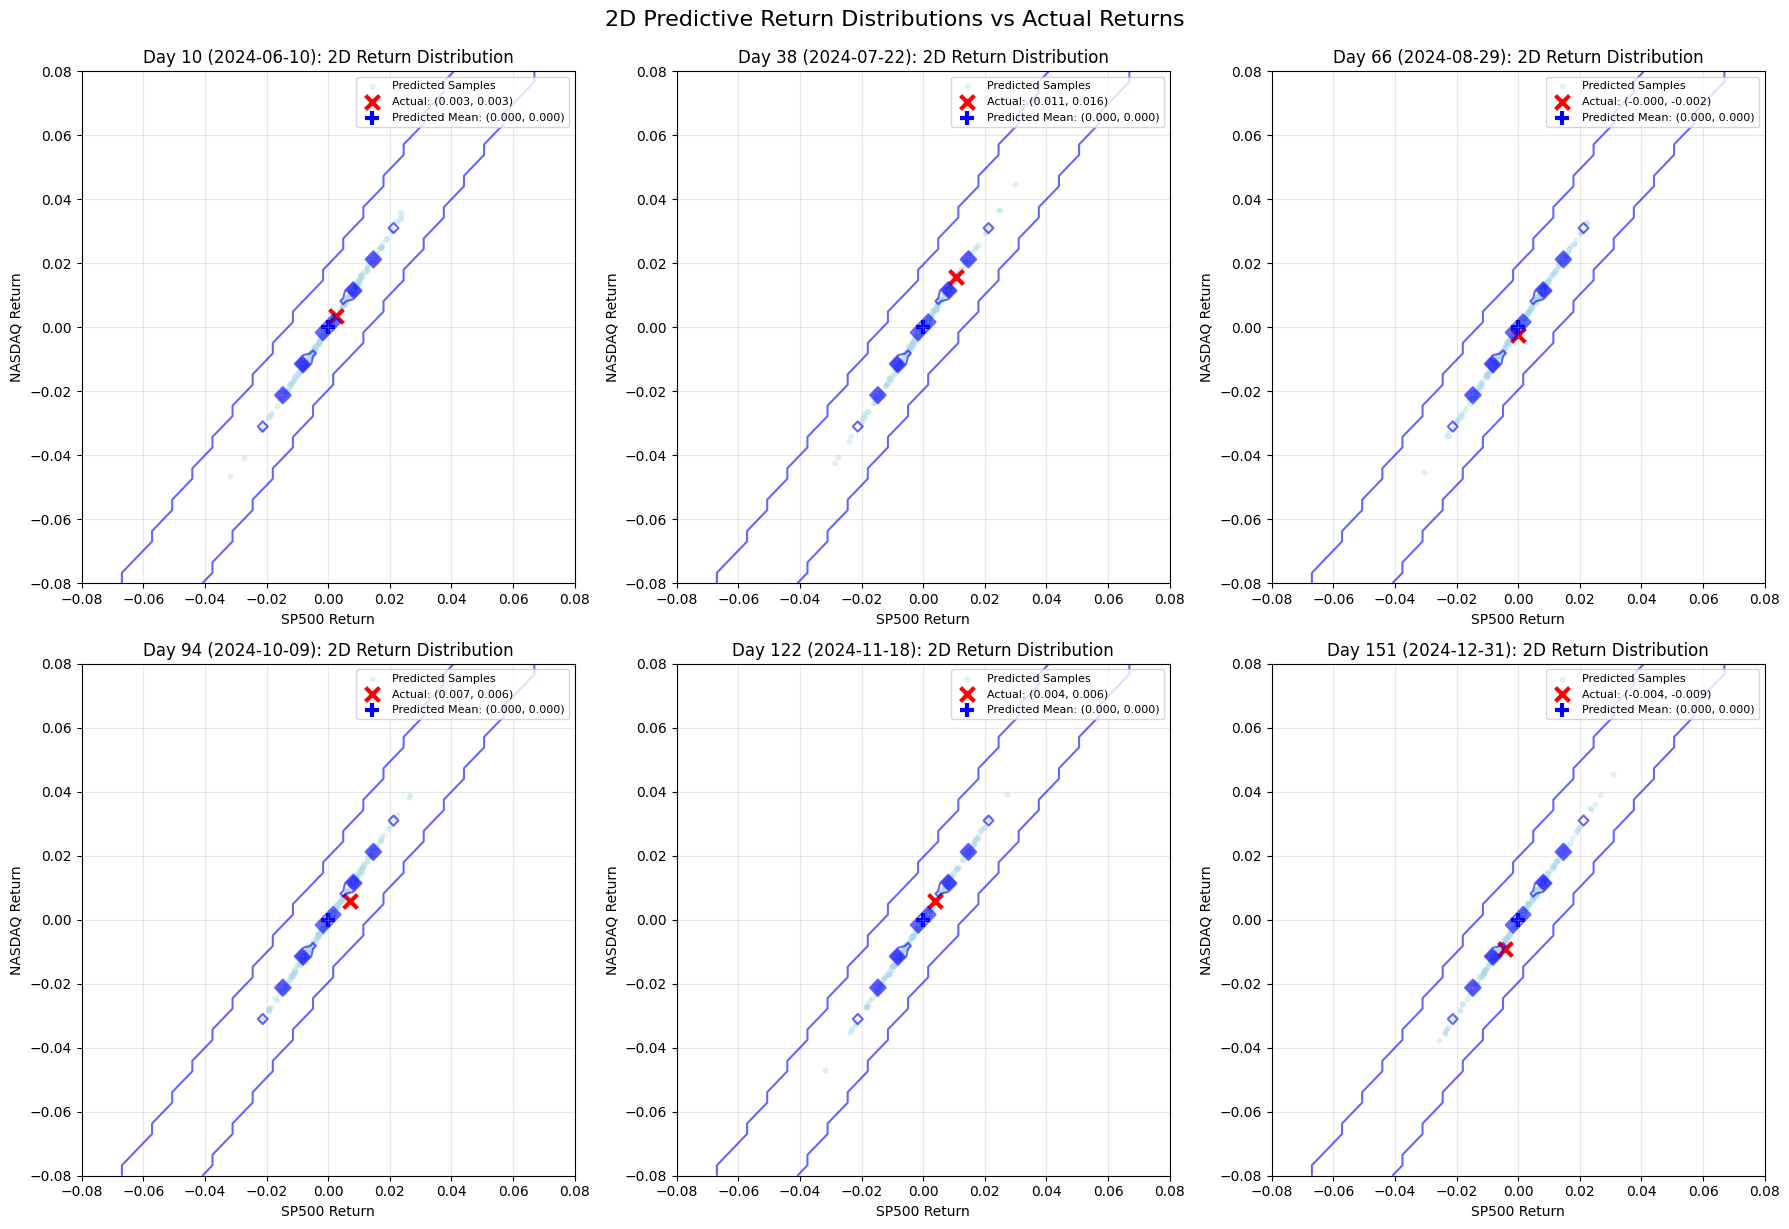

2. 2D Prediction intervals and coverage:
Falling back to constant volatilities: filtering_results not available
Using constant volatilities from DC-MSV parameters


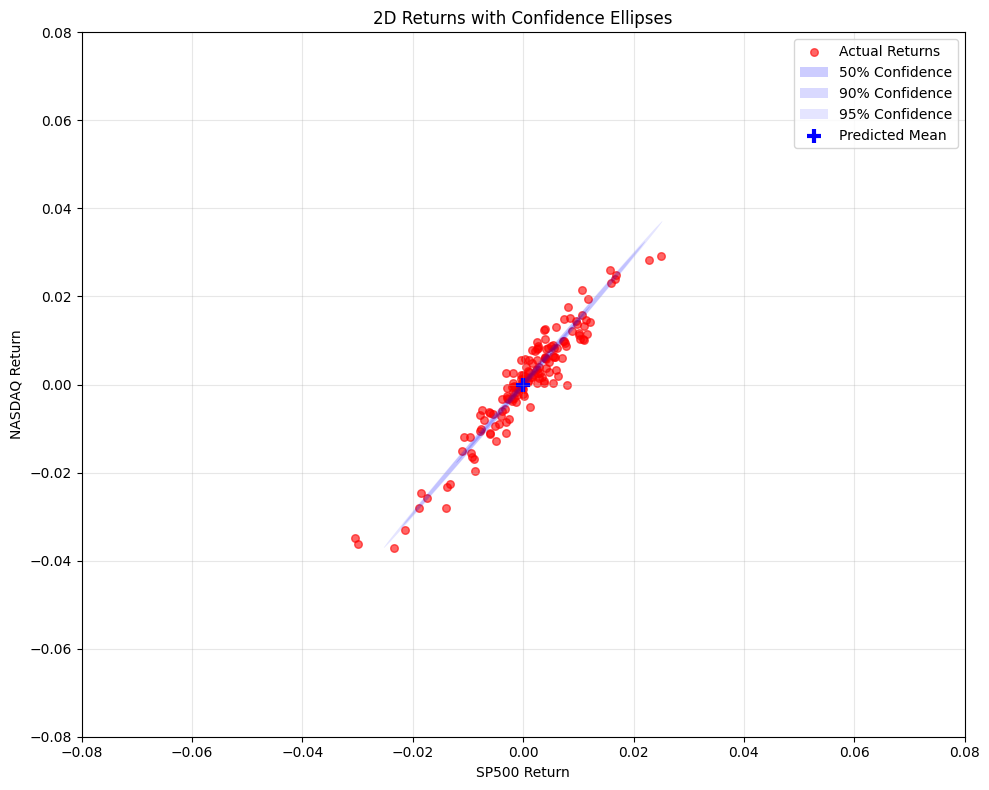

📊 2D Prediction Coverage Statistics:
Multivariate Coverage (Mahalanobis):
  50% region: 10.6% (target: 50%)
  90% region: 23.8% (target: 90%)
  95% region: 27.8% (target: 95%)
3. Correlation structure analysis:


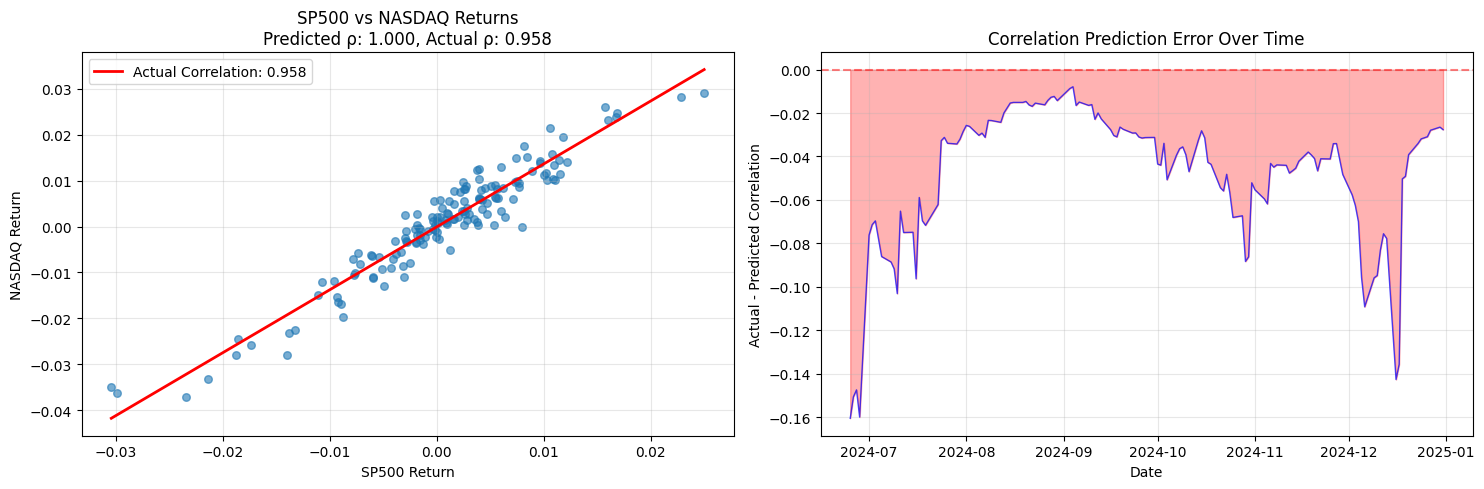

📊 Correlation Analysis Summary:
DC-MSV Predicted Correlation: 0.9996
Sample Correlation:           0.9578
Correlation Error:            0.0418
Mean 20-day Rolling Corr:     0.9513
Std 20-day Rolling Corr:      0.0320


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde

def plot_2d_return_distributions(dc_msv_params, actual_returns, test_df, n_examples=6):
    """
    Plot predictive 2D return distributions vs actual returns for selected time points
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Start from day 10 and select time points evenly spaced throughout the test period
    start_point = 9  # Day 10 (0-indexed)
    max_point = len(actual_returns) - 1
    time_points = np.linspace(start_point, max_point, n_examples, dtype=int)
    
    # Extract DC-MSV parameters
    mu1, mu2 = dc_msv_params['mu1']['mean'], dc_msv_params['mu2']['mean']
    mu0 = dc_msv_params['mu0']['mean']
    sigma1, sigma2 = dc_msv_params['sigma1']['mean'], dc_msv_params['sigma2']['mean']
    
    # Average correlation and volatilities
    rho_mean = (np.exp(mu0) - 1) / (np.exp(mu0) + 1)
    vol1 = np.exp(mu1/2) * np.exp(sigma1**2/8)
    vol2 = np.exp(mu2/2) * np.exp(sigma2**2/8)
    
    # Covariance matrix
    cov = np.array([[vol1**2, rho_mean * vol1 * vol2],
                    [rho_mean * vol1 * vol2, vol2**2]])
    
    for i, t in enumerate(time_points):
        if t < len(actual_returns):
            # Generate samples from predictive distribution
            n_samples = 1000
            pred_samples = np.random.multivariate_normal([0, 0], cov, n_samples)
            
            # Plot predictive distribution as contour
            x_range = np.linspace(-0.08, 0.08, 50)
            y_range = np.linspace(-0.08, 0.08, 50)
            X, Y = np.meshgrid(x_range, y_range)
            pos = np.dstack((X, Y))
            
            # Create multivariate normal for contour plotting
            from scipy.stats import multivariate_normal
            rv = multivariate_normal([0, 0], cov)
            
            # Plot contours
            axes[i].contour(X, Y, rv.pdf(pos), colors='blue', alpha=0.6, levels=5)
            
            # Scatter plot of samples
            axes[i].scatter(pred_samples[:200, 0], pred_samples[:200, 1], 
                           alpha=0.3, s=10, color='lightblue', label='Predicted Samples')
            
            # Add actual return as red point
            actual_sp500 = actual_returns[t, 0]
            actual_nasdaq = actual_returns[t, 1]
            axes[i].scatter(actual_sp500, actual_nasdaq, color='red', s=100, 
                           marker='x', linewidth=3, label=f'Actual: ({actual_sp500:.3f}, {actual_nasdaq:.3f})')
            
            # Add predicted mean
            axes[i].scatter(0, 0, color='blue', s=100, marker='+', linewidth=3,
                           label='Predicted Mean: (0.000, 0.000)')
            
            date_str = test_df.index[t].strftime('%Y-%m-%d')
            axes[i].set_title(f'Day {t+1} ({date_str}): 2D Return Distribution')
            axes[i].set_xlabel('SP500 Return')
            axes[i].set_ylabel('NASDAQ Return')
            axes[i].legend(fontsize=8)
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlim(-0.08, 0.08)
            axes[i].set_ylim(-0.08, 0.08)
    
    plt.tight_layout()
    plt.suptitle('2D Predictive Return Distributions vs Actual Returns', y=1.02, fontsize=16)
    plt.show()

def plot_2d_quantile_analysis(dc_msv_params, actual_returns, test_df):
    """
    Analyze 2D prediction quality using time-varying volatilities from filtering results
    """
    # Try to use filtering results for time-varying volatilities if available
    try:
        if 'filtering_results' in globals() and filtering_results is not None:
            # Check if filtering_results has the expected structure
            if isinstance(filtering_results, dict) and 'filtered_states' in filtering_results:
                # Extract time-varying volatilities from filtered states
                filtered_states = filtering_results['filtered_states']
                h1_filtered = filtered_states['h1_mean']
                h2_filtered = filtered_states['h2_mean'] 
                q_filtered = filtered_states['q_mean']
                
                # Convert to actual volatilities and correlations (daily scale)
                vol1_daily = np.exp(h1_filtered / 2)  # Daily volatility
                vol2_daily = np.exp(h2_filtered / 2)  # Daily volatility
                rho_daily = (np.exp(q_filtered) - 1) / (np.exp(q_filtered) + 1)
                
                # Ensure we have the right length (match test period)
                n_periods = len(actual_returns)
                if len(vol1_daily) > n_periods:
                    vol1_daily = vol1_daily[:n_periods]
                    vol2_daily = vol2_daily[:n_periods]
                    rho_daily = rho_daily[:n_periods]
                elif len(vol1_daily) < n_periods:
                    # Extend with last values if needed
                    vol1_daily = np.pad(vol1_daily, (0, n_periods - len(vol1_daily)), 'edge')
                    vol2_daily = np.pad(vol2_daily, (0, n_periods - len(vol2_daily)), 'edge')
                    rho_daily = np.pad(rho_daily, (0, n_periods - len(rho_daily)), 'edge')
                
                print("Using time-varying volatilities from filtering results")
                use_time_varying = True
            else:
                raise KeyError("filtering_results structure not as expected")
        else:
            raise NameError("filtering_results not available")
    except (NameError, KeyError, IndexError, TypeError) as e:
        print(f"Falling back to constant volatilities: {e}")
        use_time_varying = False
        
    if not use_time_varying:
        # Fallback: use constant estimates from DC-MSV parameters
        mu1, mu2 = dc_msv_params['mu1']['mean'], dc_msv_params['mu2']['mean']
        mu0 = dc_msv_params['mu0']['mean']
        sigma1, sigma2 = dc_msv_params['sigma1']['mean'], dc_msv_params['sigma2']['mean']
        
        # Constant volatilities and correlation
        vol1_const = np.exp(mu1/2) * np.exp(sigma1**2/8)
        vol2_const = np.exp(mu2/2) * np.exp(sigma2**2/8)
        rho_const = (np.exp(mu0) - 1) / (np.exp(mu0) + 1)
        
        # Create arrays for time-varying (but actually constant) values
        n_periods = len(actual_returns)
        vol1_daily = np.full(n_periods, vol1_const)
        vol2_daily = np.full(n_periods, vol2_const)
        rho_daily = np.full(n_periods, rho_const)
        print("Using constant volatilities from DC-MSV parameters")
    
    n_periods = len(actual_returns)
    
    # Calculate time-varying prediction intervals
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    sp500_quantiles_time = np.zeros((5, n_periods))
    nasdaq_quantiles_time = np.zeros((5, n_periods))
    
    for t in range(n_periods):
        for i, q in enumerate(quantiles):
            sp500_quantiles_time[i, t] = stats.norm.ppf(q, 0, vol1_daily[t])
            nasdaq_quantiles_time[i, t] = stats.norm.ppf(q, 0, vol2_daily[t])
    
    
    # Calculate time-varying Mahalanobis distances
    from scipy.stats import chi2
    mahal_distances = []
    for t in range(n_periods):
        # Time-varying covariance matrix
        cov_t = np.array([[vol1_daily[t]**2, rho_daily[t] * vol1_daily[t] * vol2_daily[t]],
                         [rho_daily[t] * vol1_daily[t] * vol2_daily[t], vol2_daily[t]**2]])
        diff = actual_returns[t] - np.array([0, 0])
        mahal_dist = np.sqrt(diff.T @ np.linalg.inv(cov_t) @ diff)
        mahal_distances.append(mahal_dist)
    
    mahal_distances = np.array(mahal_distances)
    
    # Create time-varying prediction intervals 
    dates = test_df.index[:len(actual_returns)]
    
    # Create single plot - only 2D scatter with confidence ellipses
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # 2D scatter plot with confidence ellipses using average covariance
    from matplotlib.patches import Ellipse
    
    # Use average covariance for ellipse visualization
    avg_vol1 = np.mean(vol1_daily)
    avg_vol2 = np.mean(vol2_daily)
    avg_rho = np.mean(rho_daily)
    avg_cov = np.array([[avg_vol1**2, avg_rho * avg_vol1 * avg_vol2],
                       [avg_rho * avg_vol1 * avg_vol2, avg_vol2**2]])
    
    # Plot actual returns
    ax.scatter(actual_returns[:, 0], actual_returns[:, 1], 
               alpha=0.6, s=30, color='red', label='Actual Returns')
    
    # Add confidence ellipses
    eigenvals, eigenvecs = np.linalg.eigh(avg_cov)
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    
    # 50%, 90%, 95% confidence ellipses
    for confidence, color, alpha in [(0.5, 'blue', 0.2), (0.9, 'blue', 0.15), (0.95, 'blue', 0.1)]:
        chi2_val = chi2.ppf(confidence, df=2)
        width = 2 * np.sqrt(chi2_val * eigenvals[0])
        height = 2 * np.sqrt(chi2_val * eigenvals[1])
        
        ellipse = Ellipse(xy=(0, 0), width=width, height=height, angle=angle,
                         facecolor=color, alpha=alpha, label=f'{confidence*100:.0f}% Confidence')
        ax.add_patch(ellipse)
    
    ax.scatter(0, 0, color='blue', s=100, marker='+', linewidth=3, label='Predicted Mean')
    ax.set_title('2D Returns with Confidence Ellipses')
    ax.set_xlabel('SP500 Return')
    ax.set_ylabel('NASDAQ Return')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.08, 0.08)
    ax.set_ylim(-0.08, 0.08)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate coverage statistics using multivariate Mahalanobis distance only
    # Multivariate coverage using Mahalanobis distance
    mahal_coverage_50 = np.mean(mahal_distances**2 <= chi2.ppf(0.5, df=2))
    mahal_coverage_90 = np.mean(mahal_distances**2 <= chi2.ppf(0.9, df=2))
    mahal_coverage_95 = np.mean(mahal_distances**2 <= chi2.ppf(0.95, df=2))
    
    print(f"📊 2D Prediction Coverage Statistics:")
    print(f"=" * 50)
    print(f"Multivariate Coverage (Mahalanobis):")
    print(f"  50% region: {mahal_coverage_50:.1%} (target: 50%)")
    print(f"  90% region: {mahal_coverage_90:.1%} (target: 90%)")
    print(f"  95% region: {mahal_coverage_95:.1%} (target: 95%)")
    
    return {
        'multivariate_coverage': (mahal_coverage_50, mahal_coverage_90, mahal_coverage_95),
        'mahalanobis_distances': mahal_distances
    }

def plot_correlation_analysis(dc_msv_params, actual_returns, test_df):
    """
    Analyze the predicted vs actual correlation structure
    """
    # Extract DC-MSV correlation parameter
    mu0 = dc_msv_params['mu0']['mean']
    predicted_correlation = (np.exp(mu0) - 1) / (np.exp(mu0) + 1)
    
    # Calculate rolling correlation of actual returns
    returns_df = pd.DataFrame(actual_returns, columns=['SP500', 'NASDAQ'], index=test_df.index[:len(actual_returns)])
    
    # Different window sizes for rolling correlation
    windows = [20, 50, 100]
    
    # Only keep the second row plots - create 1 row with 2 plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Calculate sample correlation
    sample_correlation = np.corrcoef(actual_returns.T)[0, 1]
    
    # 1. Scatter plot of returns with correlation info (was axes[1, 0])
    axes[0].scatter(actual_returns[:, 0], actual_returns[:, 1], alpha=0.6, s=30)
    
    # Add regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(actual_returns[:, 0], actual_returns[:, 1])
    line_x = np.array([actual_returns[:, 0].min(), actual_returns[:, 0].max()])
    line_y = slope * line_x + intercept
    axes[0].plot(line_x, line_y, 'r-', linewidth=2, 
                   label=f'Actual Correlation: {r_value:.3f}')
    
    axes[0].set_title(f'SP500 vs NASDAQ Returns\nPredicted ρ: {predicted_correlation:.3f}, Actual ρ: {r_value:.3f}')
    axes[0].set_xlabel('SP500 Return')
    axes[0].set_ylabel('NASDAQ Return')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Correlation error over time (was axes[1, 1])
    if len(returns_df) >= 20:
        rolling_corr_20 = returns_df['SP500'].rolling(window=20).corr(returns_df['NASDAQ'])
        corr_error = rolling_corr_20 - predicted_correlation
        
        axes[1].plot(corr_error.index, corr_error.values, 'b-', linewidth=1, alpha=0.7)
        axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[1].fill_between(corr_error.index, corr_error.values, 0, 
                               where=(corr_error.values > 0), alpha=0.3, color='green', interpolate=True)
        axes[1].fill_between(corr_error.index, corr_error.values, 0, 
                               where=(corr_error.values <= 0), alpha=0.3, color='red', interpolate=True)
        axes[1].set_title('Correlation Prediction Error Over Time')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Actual - Predicted Correlation')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation analysis summary
    print(f"📊 Correlation Analysis Summary:")
    print(f"=" * 40)
    print(f"DC-MSV Predicted Correlation: {predicted_correlation:.4f}")
    print(f"Sample Correlation:           {sample_correlation:.4f}")
    print(f"Correlation Error:            {abs(sample_correlation - predicted_correlation):.4f}")
    
    if len(returns_df) >= 20:
        rolling_corr_20 = returns_df['SP500'].rolling(window=20).corr(returns_df['NASDAQ']).dropna()
        mean_rolling_corr = rolling_corr_20.mean()
        std_rolling_corr = rolling_corr_20.std()
        
        print(f"Mean 20-day Rolling Corr:     {mean_rolling_corr:.4f}")
        print(f"Std 20-day Rolling Corr:      {std_rolling_corr:.4f}")
    
    return {
        'predicted_correlation': predicted_correlation,
        'sample_correlation': sample_correlation,
        'correlation_error': abs(sample_correlation - predicted_correlation)
    }

# Run the 2D visualizations
print("📊 Creating 2D return distribution visualizations...")

# 1. 2D Distribution snapshots at different time points
print("1. 2D Predictive distributions at selected time points:")
plot_2d_return_distributions(results['estimates'], test_array_decimal, test_df)

# 2. 2D Quantile-based analysis
print("2. 2D Prediction intervals and coverage:")
coverage_stats_2d = plot_2d_quantile_analysis(results['estimates'], test_array_decimal, test_df)

# 3. Correlation analysis
print("3. Correlation structure analysis:")
correlation_stats = plot_correlation_analysis(results['estimates'], test_array_decimal, test_df)